# Final Project of Unsupervised Algorithms in Machine Learning
## BBC News Classification
## Introduction
Welcome to the final project of Unsupervised Algorithms in Machine Learning. So this project is about BBC News Classification.In this project, I used machine learning techniques to classify BBC news stories into predetermined categories. Natural language processing (NLP) frequently handles the duty of classifying news, which helps condense large volumes of data into meaningful clusters for faster retrieval and analysis of pertinent content.
## Problem Discussion
The main difficulty lies in correctly categorising news stories according to their textual content into the appropriate groups (such as business, politics, sports, tech, and entertainment). This assignment entails:

- Removing noise from the text data by cleaning and preparing it.
- Taking significant elements out of the text.
- Utilising machine learning techniques to classify the articles and find trends.
## Approach for the solution
We employ Non-negative Matrix Factorization (NMF) for the unsupervised learning strategy. NMF is an effective topic modelling method that looks for latent topics in a set of documents without using labels that have already been established.
##Steps Envolved:

#### 1. Data Preprocessing:
- **Text cleaning:** It involves lemmatizing the text to minimise dimensionality and removing stop words, punctuation, and numerals using the SpaCy package.<br><br>
- **Vectorization:** Use Term Frequency-Inverse Document Frequency (TF-IDF) transformation to weigh the terms after converting the cleaned text into numerical characteristics using Count Vectorization.

#### 2. NMF Model Implementation:
- **Initialization and Fitting of the Model:** Fit the NMF model onto the TF-IDF transformed document-term matrix after initialising it with parameters such as the number of components and type of solver.<br><br>
- **Subject Assigning:** Convert the document-term matrix into the document-topic matrix, then designate subjects for every document according to the highest values.

#### 3. Label Mapping and Evaluation:
- **Label Permutation:** Use permutations to match the newly discovered themes to the original categories. Then, use accuracy ratings to determine which mapping is the best.<br><br>
- **Model Evaluation:** To assess the NMF model's performance, compute accuracy and create a confusion matrix.










## Loading Packages

In [1]:
%pip install watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.decomposition import NMF
import spacy
import itertools

In [3]:
%load_ext watermark
%watermark -v -n -m -p numpy,sklearn,spacy,pandas,seaborn

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy  : 1.25.2
sklearn: 1.2.2
spacy  : 3.7.5
pandas : 2.0.3
seaborn: 0.13.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.1.85+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



## Importing Datasets

In [4]:
test = pd.read_csv(r'data/BBC News Test.csv')
train = pd.read_csv(r'data/BBC News Train.csv')

## Examine, Display, and Purify the Data

In [5]:
# Look at a sample text
train.sample(1)['Text'].values

array(['sony psp console hits us in march us gamers will be able to buy sony s playstation portable from 24 march  but there is no news of a europe debut.  the handheld console will go on sale for $250 (£132) and the first million sold will come with spider-man 2 on umd  the disc format for the machine. sony has billed the machine as the walkman of the 21st century and has sold more than 800 000 units in japan. the console (12cm by 7.4cm) will play games  movies and music and also offers support for wireless gaming. sony is entering a market which has been dominated by nintendo for many years.  it launched its ds handheld in japan and the us last year and has sold 2.8 million units. sony has said it wanted to launch the psp in europe at roughly the same time as the us  but gamers will now fear that the launch has been put back. nintendo has said it will release the ds in europe from 11 march.  it has gaming at its core  but it s not a gaming device. it s an entertainment device   said 

Counting the number of categories indicates that none are clearly undersampled.




<ipython-input-6-c6ab3962c70b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_counts,


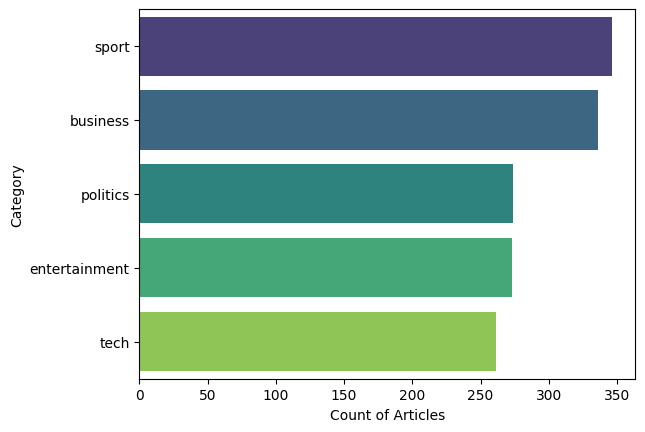

In [6]:

category_counts = train['Category'].value_counts().to_frame().reset_index()
category_counts.columns = ['Category', 'Count']
sns.barplot(data=category_counts,
            y='Category',
            x='Count',
            palette='viridis')
plt.ylabel('Category')
plt.xlabel('Count of Articles')
plt.show()

Examining the word count distribution for each category in more detail




In [7]:
train['NumberOfWords'] = train['Text'].str.split().apply(len)

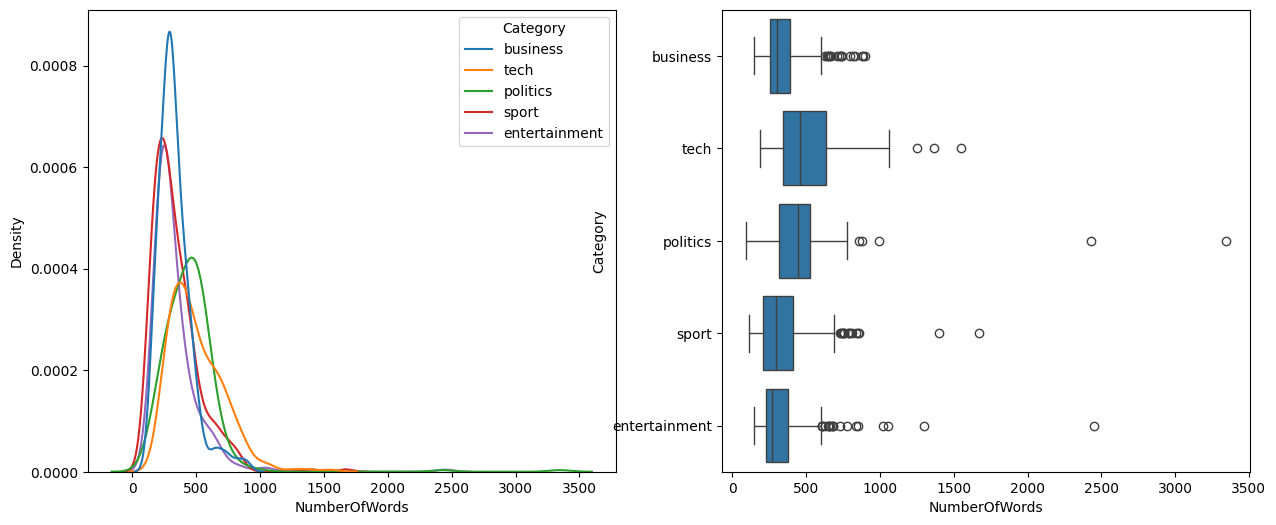

In [9]:
figs, axs = plt.subplots(ncols=2,
                        figsize=(15,6))

g1 = sns.kdeplot(data=train,
        x='NumberOfWords',
        hue='Category',
           ax=axs[0])

g2 = sns.boxplot(data=train,
            x='NumberOfWords',
            y='Category',
           ax=axs[1])

Every category's text length falls within a similar range. A few chosen pieces within the 'politics' category appear to be rather lengthy (>2000 words). We may examine each one separately to ensure that it is accurate.


In [10]:
train.sort_values('NumberOfWords', ascending=False).head(5)['Text']

1057    minimum wage increased to £5.05 the minimum wa...
454     roundabout continues nostalgia trip the new bi...
1258    kilroy launches  veritas  party ex-bbc chat sh...
364     all black magic: new zealand rugby playing col...
120     apple laptop is  greatest gadget  the apple po...
Name: Text, dtype: object

## Constructing and instructing models
### Unsupervised Model (NMF)
We must perform some further data cleaning and text feature engineering before we can begin building our model. For this, the SpaCy library will be utilised.
### Utilising spacy, lemmatize and eliminate stop words
Certain stop words, including "the," "if," and so on, have no classification significance; they can be eliminated along with punctuation and numbers in text.




In [11]:
!python3 -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 18.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [12]:
#Load a medium trained model
nlp = spacy.load("en_core_web_md")

In [13]:
def cleaner(note):
    """Remove stop words, punctuations, convert words into lemma_"""
    doc = nlp(note)
    return (" ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.like_num]))

In [14]:
# This may take upto few minutes to execute
train['Text'] = train['Text'].astype(str).apply(cleaner)

We first obtain word counts in order to compute their tf-dif (term frequency-inverse document frequency), which will be supplied to our model in order to build our text document. This is a crucial step because tf-dif assists in identifying pertinent terms that aren't used frequently in the document.




In [15]:
counter = CountVectorizer()
bag = counter.fit_transform(train['Text'].values)

In [17]:
# Bag contains a sparse matix of all document, word combinations as a 1-gram model (broken off by single words)
bag.toarray().shape

(1490, 18824)

In [19]:
# Apply tf-idf technique to weight down frequent words appearing in all docs
tfidf_vec = TfidfTransformer(use_idf=True,
                             norm='l2', # Apply l2 normalization
                             smooth_idf=True) # Assigns zero weights to terms occuring in all dosc

In [20]:
tfidf_run = tfidf_vec.fit_transform(bag)

Grid search can be used to adjust the model's tf-idf and NMF parameters; however, for this project, we just made a few ad hoc modifications and chose an NMF model that used kullback-leibler beta_loss.

| Parameter | Accuracy |
|-----------|----------|
| beta_loss = frobenius, solver = cd | 0.9201 |
| beta_loss = frobenius, solver = mu | 0.9154 |
| beta_loss = kullback-leibler, solver = mu | 0.9423 |

In [21]:
# Fit a NMF model on the tf-dif values
nmf = NMF(solver='mu',
          n_components=5, # The number of topics we want
          beta_loss='kullback-leibler', #
          random_state=42)
nmf.fit(tfidf_run)

NMF(beta_loss='kullback-leibler', n_components=5, random_state=42, solver='mu')

In [22]:
# We can get the max position of the transform using argmax
predicted_labels = nmf.transform(tfidf_run).argmax(axis=1)
predicted_labels

array([4, 4, 4, ..., 4, 2, 2])

In [23]:
def label_permute_compare(y_actual, y_pred, n=5):
    """
    Args:
        y_actual -> pd.Series with categories as text
        y_pred -> np.array with predictions
        n -> Number of permutations in y_pred
    Returns:
        Predicted labels, accuracy score
    """
    all_scores = []
    actual_labels = y_actual.unique().tolist()

    # Generate permutations to check against
    for perm in itertools.permutations((0, 1, 2, 3, 4), 5):
        remap_dict = dict(zip(actual_labels, perm))
        # Change the values in the prediction
        y_actual_coded = y_actual.replace(remap_dict)
        acc = accuracy_score(y_actual_coded, y_pred)
        all_scores.append([perm, acc])

    best_score = sorted(all_scores, key=lambda x:x[1])[-1]

    return best_score, actual_labels

In [24]:
# We pass the max values into a function to predict the labels
label_predictions = label_permute_compare(train['Category'], predicted_labels)

# Print the results
print(f'Labels are -> {label_predictions[0][0]} for {label_predictions[1]}\
\n Accuracy -> {label_predictions[0][1]}')

Labels are -> (4, 2, 1, 0, 3) for ['business', 'tech', 'politics', 'sport', 'entertainment']
 Accuracy -> 0.9389261744966443


In [25]:
label_category_mapping = dict(zip(label_predictions[0][0], label_predictions[1]))
label_category_mapping

{4: 'business', 2: 'tech', 1: 'politics', 0: 'sport', 3: 'entertainment'}

In [26]:
train_results = train.copy().assign(Predictions=list(map(label_category_mapping.get, predicted_labels)))
train_results.sample(5)

,ArticleId,Text,Category,NumberOfWords,Predictions
954,679,oscar host rock clean oscar host chris rock sa...,entertainment,243,entertainment
974,943,butler strike gold spain britain s kathy butle...,sport,175,sport
1122,458,podcast mark rise diy radio apple ipod digital...,tech,1045,tech
1321,1791,brown name march budget chancellor gordon brow...,politics,253,politics
723,1366,j&j agree $ 25bn guidant deal pharmaceutical g...,business,189,business


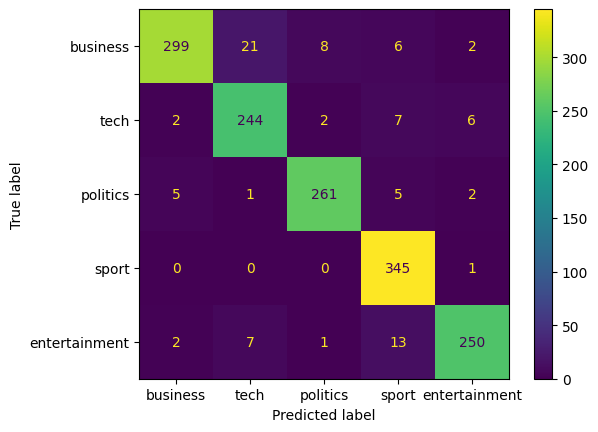

In [27]:
cf_m = ConfusionMatrixDisplay(confusion_matrix(train_results['Category'],
                                               train_results['Predictions'],
                                               labels=label_predictions[1]),
                                               display_labels=label_predictions[1])
cf_m.plot()

### Test Predictions
The pre-processing procedures we used on the training dataset must be repeated.

In [28]:
# Spacy to clean text, this might take some time
test['Text'] = test['Text'].astype(str).apply(cleaner)

In [29]:
bag_test = counter.transform(test['Text'].values)

In [30]:
tfidf_test_run = tfidf_vec.transform(bag_test)

In [31]:
# We can get the max position of the transform using argmax
test_predicted_labels = nmf.transform(tfidf_test_run).argmax(axis=1)

In [32]:
test_results = test.copy().assign(Category=list(map(label_category_mapping.get, test_predicted_labels)))
test_results.sample(5)

,ArticleId,Text,Category
167,1654,file swapper ready new network legal attack we...,tech
409,968,kidman win photographer battle actress nicole ...,politics
156,635,mutu hold talk juventus disgrace chelsea strik...,sport
339,34,mtv s osbournes rock star ozzy osbourne say fa...,entertainment
85,1307,afflict award fatigue film world medium wi...,entertainment


In [33]:
test_results[['ArticleId', 'Category']].to_csv(r'predictions/unsupervised_predictions.csv', index=False)

The unsupervised test public score was 0.92789



## Compare with supervised learning
### Supervised Model
We will now use a supervised model (KNN) to predict the categories.

In [34]:
from sklearn.neighbors import KNeighborsClassifier

In [35]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(tfidf_run.toarray(), train['Category'])

KNeighborsClassifier()

In [36]:
category_predictions = knn.predict(tfidf_run.toarray())

In [37]:
accuracy_score(train['Category'], category_predictions)

0.9583892617449664

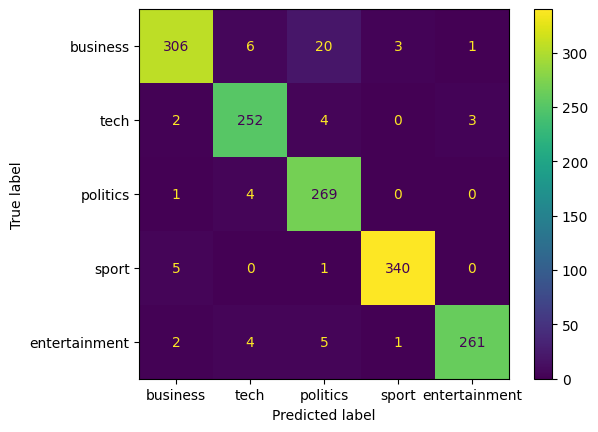

In [38]:
cf_m_sup = ConfusionMatrixDisplay(confusion_matrix(train['Category'],
                                                   category_predictions,
                                                   labels=label_predictions[1]),
                                                   display_labels=label_predictions[1])
cf_m_sup.plot()

### Tests Predictions


In [39]:
test_category_predictions = knn.predict(tfidf_test_run.toarray())

In [40]:
test_results_supervised = test.copy().assign(Category=test_category_predictions)
test_results_supervised.sample(5)

,ArticleId,Text,Category
663,1145,mcdonald s sponsor mtv mcdonald s world s la...,entertainment
493,652,wife swap maker sue copycat british produc...,entertainment
471,621,israel look bank chief israel ask banker inter...,business
300,402,progress new internet domain early net new dom...,tech
336,1987,uk set cut embassy overseas embassy high commi...,politics


In [41]:
test_results_supervised[['ArticleId', 'Category']].to_csv(r'predictions/supervised_predictions.csv', index=False)

The supervised test public score was 0.94829



### Using just a sample of the data to check.



In [42]:
train_50 = train.groupby('Category', group_keys=False).apply(lambda x: x.sample(frac=.5)).copy()

In [43]:
# Check that the fractions are maintained
train_50['Category'].value_counts(normalize=True)

Category
sport            0.232527
business         0.225806
politics         0.184140
entertainment    0.182796
tech             0.174731
Name: proportion, dtype: float64

## Results and Discussion
For both the training and test datasets, the supervised model outperformed the unsupervised model; however, it still had room for improvement.

This pattern persisted when the dataset was reduced to 50% by substituting train_50 for each trained value. The following are the outcomes:

- The unsupervised training and testing results are 0.9389 and 0.9278.
- The supervised training and testing results are 0.9583 and 0.94829.



Thank you for reviewing my project.<br>
~ SmitaM

## Bibliographies
Datasets - https://www.kaggle.com/competitions/learn-ai-bbc/data<br>
Sklearn Library https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html<br>
Spacy https://spacy.io/usage/spacy-101<br>
ML Book https://github.com/rasbt/machine-learning-book<br>